In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
len(X[0]) # 28 * 28

784

In [ ]:
X.shape

(70000, 784)

In [ ]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
y.shape

(70000,)

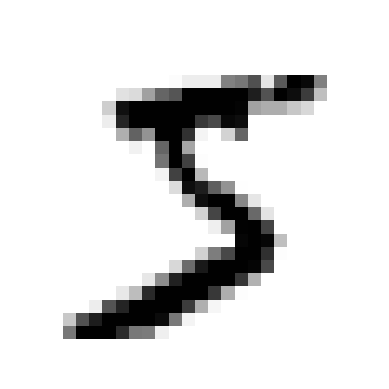

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1. KNeighbours Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc_clf = KNeighborsClassifier()
knc_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knc_clf.score(X_test, y_test)

0.9688

In [ ]:
knc_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'weights':['uniform', 'distance'], 'n_neighbors':[1, 2, 3, 4, 5, 6]}
grid_search = GridSearchCV(knc_clf, params)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3, weights='distance'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']})

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

0.9441999999999998

In [ ]:
# Running the best params on the entire training_data
knc_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knc_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
knc_clf.score(X_test, y_test)

0.9714

## 2. Data Augmentation

In [ ]:
from scipy.ndimage import shift

def shift_image(img, dx, dy):
  image = img.reshape((28, 28))
  shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
  return shifted_image.reshape([-1])

In [ ]:
image = X_train[15]
image_shifted_right = shift_image(image, 5, 0)
image_shifted_left = shift_image(image, -5, 0)

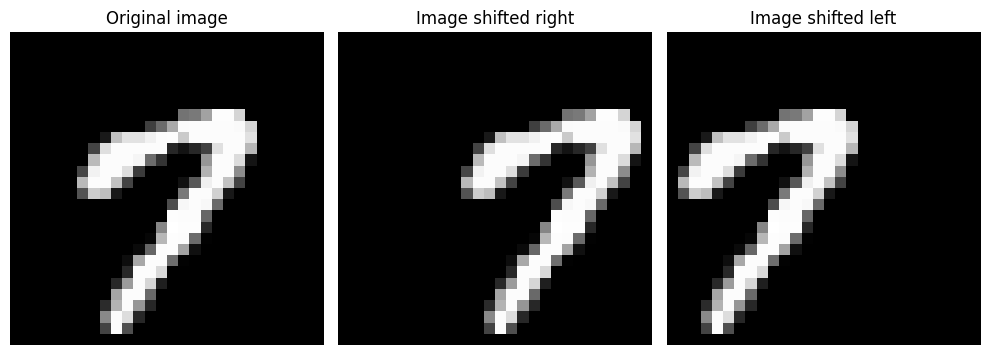

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# plt.gray()  # show the filtered result in grayscale
# plt.cmaps()
right, middle, left = axes
for ax in axes:
    ax.set_axis_off()  # remove coordinate system
right.imshow(image.reshape(28, 28))
right.set_title("Original image")
middle.imshow(image_shifted_right.reshape(28, 28))
middle.set_title("Image shifted right")
left.imshow(image_shifted_left.reshape(28, 28))
left.set_title("Image shifted left")
fig.tight_layout()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
knn_clf.score(X_test, y_test)

0.9763

## 3. Tackle the Titanic dataset
[Dataset](https://www.kaggle.com/c/titanic/data)

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [ ]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data.shape

(891, 11)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- 6 numeric columns
- 5 categorical columns

In [ ]:
train_data["Name"].value_counts() # Since all the passengers have a unique name, it might not be much useful for the time being

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

In [ ]:
train_data["Ticket"].value_counts() # It might take a lot of time and there  is not much that can be derived from the ticket column.

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [ ]:
# Let's drop Name, Ticket
train_data = train_data.drop(["Name", "Ticket"],axis=1)

In [ ]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S


In [ ]:
train_data.shape

(891, 9)

In [ ]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_data["Survived"].value_counts() # Target Column

Survived
0    549
1    342
Name: count, dtype: int64

In [ ]:
survived = train_data[train_data["Survived"] == 1] # Since 1 means yes

In [ ]:
len(survived) / len(train_data) * 100 # It seems only 38.38% survived :(

38.38383838383838

In [ ]:
train_data["Pclass"].value_counts() # Passenger Class 1 -> Upper, 2 -> Middle, 3 -> Lower

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [ ]:
train_data["Embarked"].value_counts() # C = Cherbourg, Q = Queenstown, S = Southampton

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [ ]:
train_data["SibSp"].value_counts() # Num of Sibling or Spouse

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [ ]:
train_data["Parch"].value_counts() # Num of Parents / child

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [ ]:
train_data["Cabin"].value_counts() #Cabin Number

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [ ]:
687 / 891

0.7710437710437711

In [ ]:
train_data.isna().sum() # Cabin is nearly 77% Null let's drop it for now

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
train_data = train_data.drop("Cabin", axis=1)

In [ ]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


## Now let's build the preprocessing pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe_encoder', OneHotEncoder(sparse_output=False))
])

In [ ]:
# Let's apply the num and cat pipelines
from sklearn.compose import ColumnTransformer

num_columns = ['Age', "SibSp", "Parch", "Fare"]
cat_columns = ['Pclass', 'Sex', 'Embarked']

preprocessing = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns)
])

In [ ]:
train_data.shape

(891, 8)

In [ ]:
X_train = preprocessing.fit_transform(train_data)
X_train.shape

(891, 12)

In [ ]:
y_train = train_data["Survived"]

## Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
X_test = preprocessing.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Let's try SVC

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8260549313358302

Let's compare the results of both the models

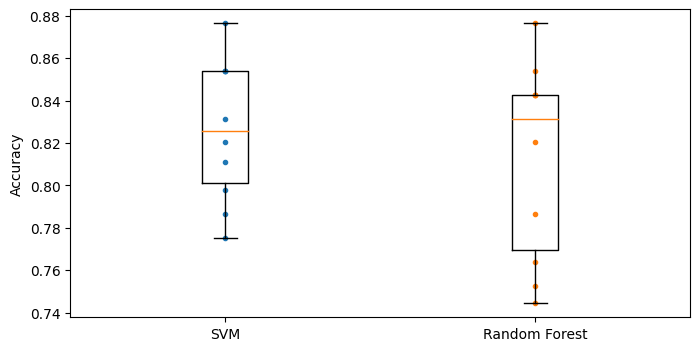

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

Though random forest got 1 best score out of the ten, it seems SVC generalises well with a better mean

**Plan to improve:**

1. Combine SibSp and Parch to get a new column `Relatives`
2. Create an Age Bucket to find the age group of people with more survival rate
3. Hyper Parameter tuning

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["AgeBucket"].value_counts()

AgeBucket
15.0    306
30.0    215
45.0     89
0.0      78
60.0     25
75.0      1
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_col(X):
  return X[:, [0]] + X[:, [1]]

def add_col_name(function_transformer, feature_names_in):
  return ["RelativesOnBoard"]

def add_col_pipeline():
  return Pipeline([
      ("imputer", SimpleImputer(strategy='median')),
      ("add_col", FunctionTransformer(add_col, feature_names_out=add_col_name)),
      ("scaler", StandardScaler())
  ])

In [ ]:
def age_bucket(X):
  return X[:, [0]] // 15 * 15

def age_bucket_name(function_transformer, feature_names_in):
  return ["AgeBucket"]

def age_bucket_pipeline():
  return Pipeline([
      ("imputer", SimpleImputer(strategy='median')),
      ('age_bucket', FunctionTransformer(age_bucket, feature_names_out=age_bucket_name)),
      ("ordinal_encoder", OrdinalEncoder()),
      ('oe_encoder', OneHotEncoder(sparse_output=False))
  ])

In [ ]:
num_columns = ["Fare"]
cat_columns = ['Pclass', 'Sex', 'Embarked']

preprocessing = ColumnTransformer([
    ('add_col_pipeline', add_col_pipeline(), ["SibSp", "Parch"]),
    ('age_bucket_pipeline', age_bucket_pipeline(), ["Age"]),
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns)
])

In [ ]:
train_data.shape

(891, 10)

In [ ]:
X_train = preprocessing.fit_transform(train_data)
X_train.shape

(891, 16)

In [ ]:
preprocessing.get_feature_names_out()

array(['add_col_pipeline__RelativesOnBoard',
       'age_bucket_pipeline__AgeBucket_0.0',
       'age_bucket_pipeline__AgeBucket_1.0',
       'age_bucket_pipeline__AgeBucket_2.0',
       'age_bucket_pipeline__AgeBucket_3.0',
       'age_bucket_pipeline__AgeBucket_4.0',
       'age_bucket_pipeline__AgeBucket_5.0', 'num_pipeline__Fare',
       'cat_pipeline__Pclass_0.0', 'cat_pipeline__Pclass_1.0',
       'cat_pipeline__Pclass_2.0', 'cat_pipeline__Sex_0.0',
       'cat_pipeline__Sex_1.0', 'cat_pipeline__Embarked_0.0',
       'cat_pipeline__Embarked_1.0', 'cat_pipeline__Embarked_2.0'],
      dtype=object)

In [ ]:
y_train = train_data["Survived"]

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.813732833957553

In [ ]:
from sklearn.svm import SVC

svc_clf = SVC(gamma="auto")
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=10)
svc_scores.mean()

0.8182022471910113

## Hyper Parameter Tuning

In [212]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42)

rfc_param_grid = [{"n_estimators": [100, 200, 300, 400, 500], "criterion": ["gini", "entropy", "log_loss"], "max_features": ["sqrt", "log2", None], 'max_depth': [7, 8, 10, 12]}]

rfc_grid_search = GridSearchCV(rfc, rfc_param_grid, cv=10)
rfc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [7, 8, 10, 12],
                          'max_features': ['sqrt', 'log2', None],
                          'n_estimators': [100, 200, 300, 400, 500]}])

In [213]:
rfc_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'n_estimators': 100}

In [215]:
rfc_grid_search.best_score_ # 84.96

0.8496629213483147

In [ ]:
svc = SVC()

svc_param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1.0, 2.0, 3.0]}]

svc_grid_search = GridSearchCV(svc, svc_param_grid, cv=10)
svc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [1.0, 2.0, 3.0],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}])

In [ ]:
svc_grid_search.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [ ]:
svc_grid_search.best_score_

0.832796504369538

In [216]:
final_model = RandomForestClassifier(**rfc_grid_search.best_params_)

In [217]:
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=None)

In [218]:
forest_scores = cross_val_score(final_model, X_train, y_train, cv=10)
forest_scores.mean()

0.8429338327091136

In [219]:
X_test = preprocessing.transform(test_data)
y_pred = final_model.predict(X_test)

In [220]:
df = pd.DataFrame(y_pred, columns=["Survived"])
df2 = test_data["PassengerId"]
df = df.set_index(df2)

In [221]:
df.shape

(418, 1)

In [222]:
df.to_csv("predictions.csv", index_label="PassengerId")

In [223]:
pd.read_csv("predictions.csv").head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
